In [1]:
import qtensor 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from cartesian_explorer import Explorer, caches

%load_ext autoreload
%autoreload 2


In [2]:
cache = caches.JobLibCache('/tmp/caex_cache')
ex = Explorer(cache=cache)

In [3]:
@ex.provider
def graph(N, seed=10):
    return qtensor.toolbox.random_graph(type='random', nodes=N, seed=seed, degree=3)

In [11]:
@ex.add_function(requires=('graph',), provides=('classical_sol', 'classical_cost'))
def classical(graph):
    cost, sol = qtensor.tools.maxcut.gurobi_maxcut(graph)
    #cost, sol = qtensor.tools.maxcut.
    return sol, cost

In [12]:
@ex.provider
def qaoa_gb(graph, p):
    if p < 10:
        gbe = np.array(qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'])
        gbe /= np.pi
        return (gbe[:p], gbe[p:])
    else:
        return

In [13]:
@ex.provider
def qaoa_cost(graph, qaoa_gb, ordering_algo='rgreedy_0.02_10'):
    g, b = qaoa_gb
    sim = qtensor.QAOAQtreeSimulator(qtensor.QtreeQAOAComposer,
                                     optimizer=qtensor.toolbox.get_ordering_algo(ordering_algo))
    return sim.energy_expectation(graph, g, b)
    

In [8]:
@ex.provider
def qaoa_sol_prob(graph, classical_sol, qaoa_gb, ordering_algo='rgreedy_0.02_10'):
    g, b = qaoa_gb
    p = len(g)
    comp = qtensor.QtreeQAOAComposer(graph, gamma=g, beta=b)
    comp.ansatz_state()
    sol = classical_sol
    N = graph.number_of_nodes()
    # the least-significatnt bit is the last in the sol
    qbit_index = list(graph.nodes)
    qbit2val = {int(n):v for n,v in zip(graph.nodes, sol)}
    sol_relab = [qbit2val[i] for i in range(N)]
    ix = np.ravel_multi_index(sol_relab, dims=[2]*N)
    sim = qtensor.QtreeSimulator(optimizer=qtensor.toolbox.get_ordering_algo(ordering_algo))
    sim.target_state = ix
    amp = sim.simulate(comp.circuit).flatten()[0]
    return amp*np.conj(amp)

In [9]:
ex.get_variable('qaoa_sol_prob', N=12, p=7)

(9.632925957565245e-09+0j)

/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/plot_functions.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  line_data = line_data.astype(np.float64)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/plot_functions.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  line_data = line_data.astype(np.float64)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/plot_functions.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  line_data = line_data.astype(np.float64)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/plot_functions.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  line_data = line_data.astype(np.float64)
/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/plot_functions.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  line_data = line_data

Text(0.5, 1.0, 'Probability to observe the optimal solution in ansatz state')

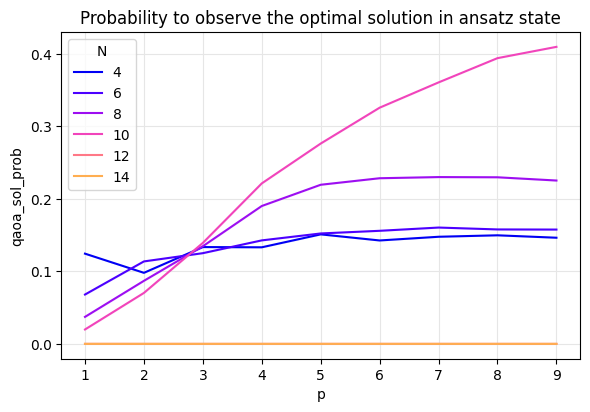

In [10]:
ex.plot_variables('qaoa_sol_prob',
                  N=[4, 6, 8, 10, 12, 14], 
                  p=range(1, 10),
                  ordering_algo=['naive'],
                  seed=[13],
                  
                 )
#plt.yscale('log')
plt.title('Probability to observe the optimal solution in ansatz state')

/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/ExplorerBasic.py:200: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(result_lin).reshape(result_shape)


Text(0.5, 1.0, 'Energy expectation value')

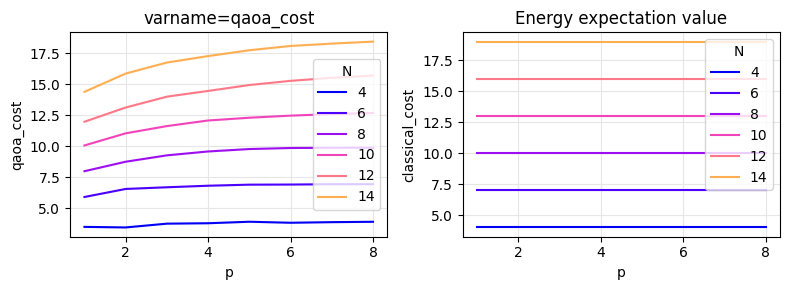

In [247]:
ex.plot_variables(('qaoa_cost', 'classical_cost'),
                  N=[4, 6, 8, 10, 12, 14], 
                  p=range(1, 9),
                  ordering_algo=['naive'],
                  seed=[13],
                  
                 )
plt.title('Energy expectation value')